# Project Anomaly Detection with Autoencoder

This notebook contains the exercises and the answers of the 5LSH0 project. Version control (https://github.com/ylnguyen/5LSH0-projects)

## Import libraries

In [3]:
import utils as util
from loss_functions import MSEloss, SSIMloss

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from importlib import reload

# autoencoder structures
import linear_autoencoder as linear
import complex_linear_autoencoder as deep_linear
import cnn_autoencoder as convolutional

C:\Users\ylngu\.conda\envs\Computer_Vision_5LSH0\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters

In [43]:
num_epochs = 15
batch_size = 256
lr = 1e-2
validation_ratio = 0.2

## Split data into train and validation set

In [5]:
# Load and transform dataset to tensor
transform = torchvision.transforms.ToTensor()

dataset = torchvision.datasets.MNIST('/files/', train=True, download=True, transform=transform)
total_images = len(dataset)

# define train and validation size
val_size = int(validation_ratio * total_images)
train_size = total_images - val_size

# split dataset into train and validation
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size], 
                                                   generator=torch.Generator().manual_seed(42))

print(len(train_set))
print(len(val_set))

48000
12000


## Get dataloaders

In [6]:
train_loader = torch.utils.data.DataLoader(train_set,
                             batch_size=batch_size, 
                             shuffle=True)

val_loader = torch.utils.data.DataLoader(val_set,
                             batch_size=batch_size, 
                             shuffle=False)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', 
                              train=False, download=True,
                              transform=transform),
                              batch_size=batch_size, 
                              shuffle=False)

## Print four test images with noise (Q1)

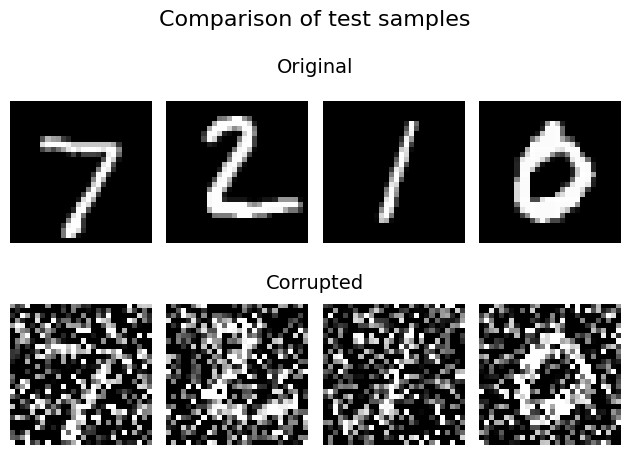

In [7]:
util.show_noisy_images(test_loader)

# Training Linear Autoencoder (Q2 - Q4)

In [8]:
# reload 
reload(linear)
reload(util)

<module 'utils' from 'C:\\Users\\ylngu\\OneDrive\\Desktop\\5LSH0 projects\\5LSH0\\autoencoder\\utils.py'>

In [21]:
# initialize models
encoder = linear.Encoder(encoding_dim=30)
decoder = linear.Decoder(encoding_dim=30)

# for accessing both parameters
autoencoder_params = [{'params': encoder.parameters()},
                      {'params': decoder.parameters()}]

# We use the Adam optimizer because it gets better predictions
optim = torch.optim.Adam(autoencoder_params, lr=lr, weight_decay=1e-05)

# Stochastic Gradient Descent optimizer (uncomment to use the SGD)
# optim = torch.optim.SGD(autoencoder_params, 
#                         lr=lr, 
#                         momentum=0.9)

In [22]:
# Define dictionary for saving the losses
losses = {'avg_train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    # train loop
    avg_train_loss, _ = util.train(encoder, decoder, train_loader, MSEloss, optim)
    # validation loop
    val_loss = util.validation(encoder, decoder, val_loader, MSEloss)
    # display losses per epoch
    print(f'Epoch {epoch+1}/{num_epochs}: train loss {avg_train_loss:.4f} \t val loss {val_loss:.4f}')
    # save losses
    losses['avg_train_loss'].append(avg_train_loss)
    losses['val_loss'].append(val_loss)
    
# Save model
torch.save(encoder, 'linear_encoder.pt')
torch.save(decoder, 'linear_decoder.pt')

Epoch 1/15: train loss 0.0471 	 val loss 0.0299
Epoch 2/15: train loss 0.0280 	 val loss 0.0269
Epoch 3/15: train loss 0.0262 	 val loss 0.0261
Epoch 4/15: train loss 0.0253 	 val loss 0.0252
Epoch 5/15: train loss 0.0248 	 val loss 0.0253
Epoch 6/15: train loss 0.0245 	 val loss 0.0247
Epoch 7/15: train loss 0.0243 	 val loss 0.0242
Epoch 8/15: train loss 0.0240 	 val loss 0.0241
Epoch 9/15: train loss 0.0240 	 val loss 0.0239
Epoch 10/15: train loss 0.0239 	 val loss 0.0241
Epoch 11/15: train loss 0.0238 	 val loss 0.0240
Epoch 12/15: train loss 0.0236 	 val loss 0.0240
Epoch 13/15: train loss 0.0236 	 val loss 0.0237
Epoch 14/15: train loss 0.0236 	 val loss 0.0237
Epoch 15/15: train loss 0.0235 	 val loss 0.0237


In [23]:
encoder = torch.load('linear_encoder.pt')
decoder = torch.load('linear_decoder.pt')

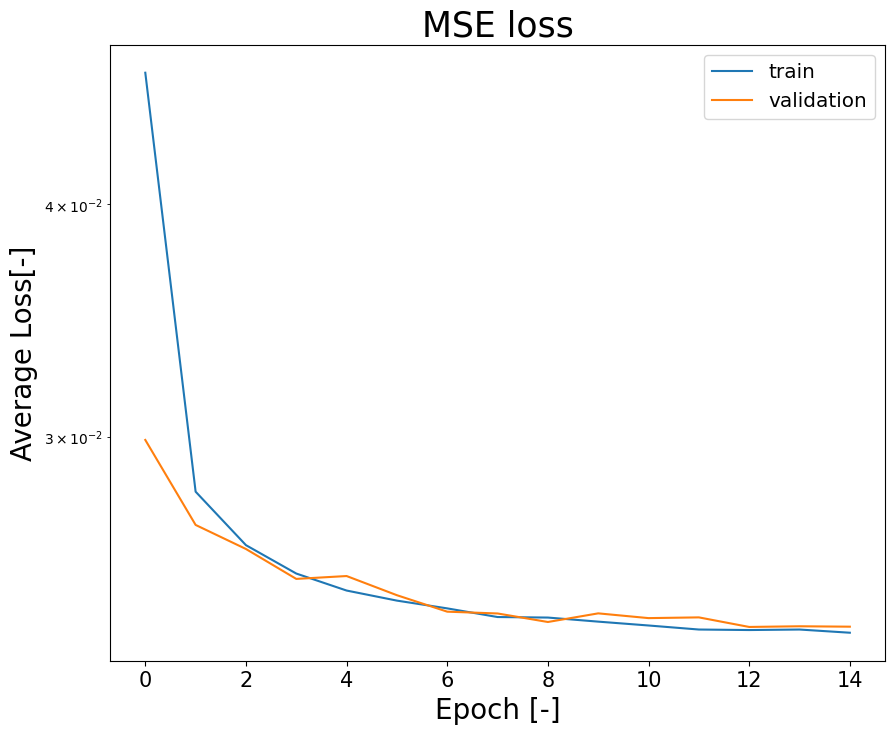

In [24]:
util.plot_losses(losses, loss_fn='MSE')

In [27]:
# test loop
outputs_inputs, _ = util.test(encoder, decoder, test_loader, MSEloss)

# outputs_inputs[0] are the reconstructed noisy batches
# outputs_inputs[1] are the corrupted input batches
# outputs_inputs[2] are the reconstructed normal batches
# outputs_inputs[3] are the normal input batches

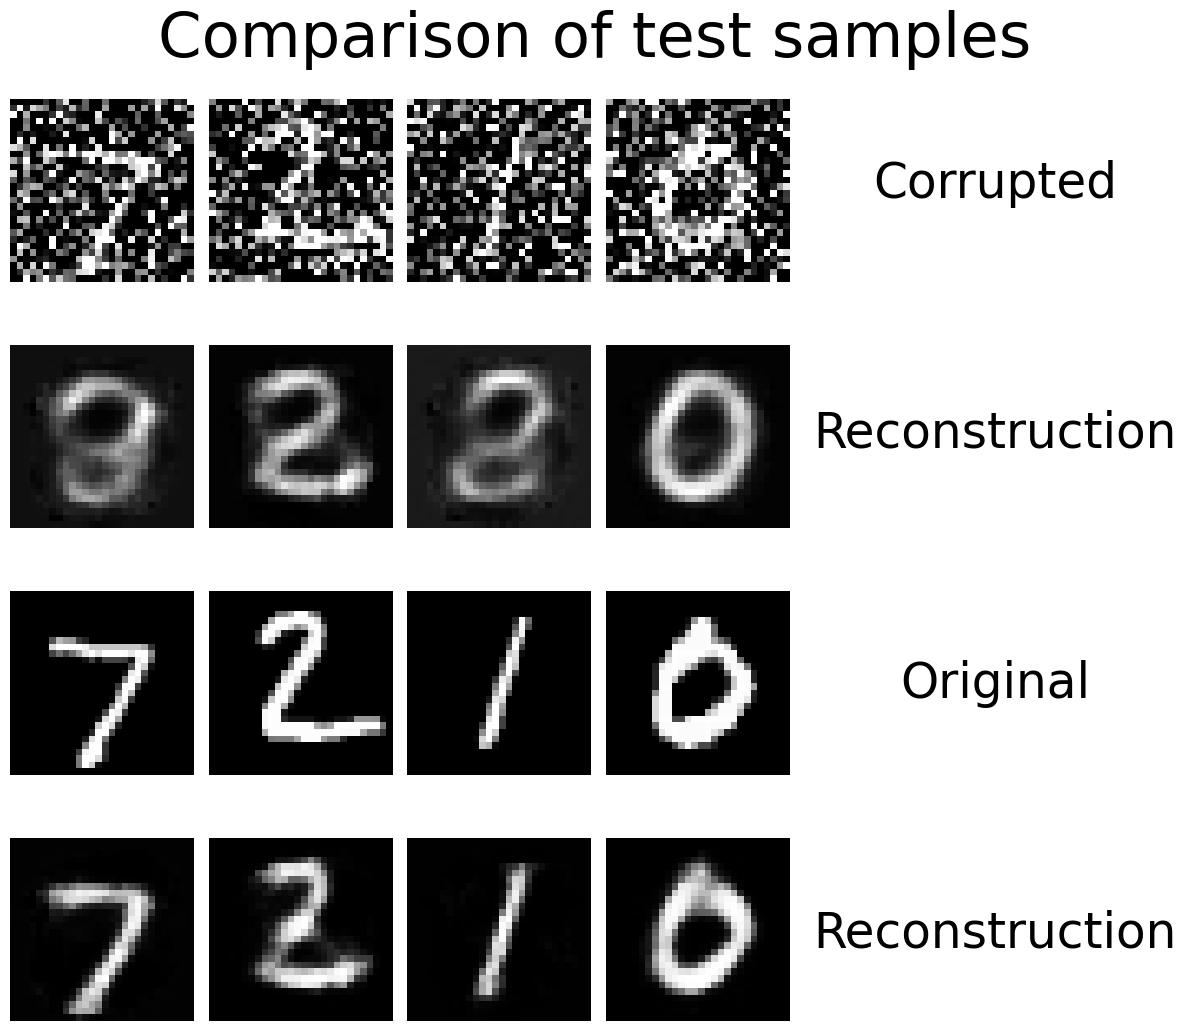

In [28]:
util.test_images(outputs_inputs[0], 
                 outputs_inputs[1], 
                 outputs_inputs[2], 
                 outputs_inputs[3])

## SSIM Loss

In [62]:
# change hyperparameter of lr and encoding dim to prevent overfitting
lr = 1e-5

# initialize models
encoder = linear.Encoder(encoding_dim=10)
decoder = linear.Decoder(encoding_dim=10)

# for accessing both parameters
autoencoder_params = [{'params': encoder.parameters()},
                      {'params': decoder.parameters()}]

# We use the Adam optimizer because it gets better predictions
optim = torch.optim.Adam(autoencoder_params, lr=lr, weight_decay=1e-05)

In [63]:
# Define dictionary for saving the losses
losses = {'avg_train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    # train loop using the SSIM loss
    avg_train_loss, _ = util.train(encoder, decoder, train_loader, SSIMloss, optim)
    # validation loop
    val_loss = util.validation(encoder, decoder, val_loader, SSIMloss)
    # display losses per epoch
    print(f'Epoch {epoch+1}/{num_epochs}: train loss {avg_train_loss:.4f} \t val loss {val_loss:.4f}')
    # save losses
    losses['avg_train_loss'].append(avg_train_loss)
    losses['val_loss'].append(val_loss)
    
# Save model with different name
torch.save(encoder, 'linear_encoder_SSIM.pt')
torch.save(decoder, 'linear_decoder_SSIM.pt')

Epoch 1/15: train loss 0.9931 	 val loss 0.9899
Epoch 2/15: train loss 0.9796 	 val loss 0.9643
Epoch 3/15: train loss 0.9441 	 val loss 0.9251
Epoch 4/15: train loss 0.9040 	 val loss 0.8673
Epoch 5/15: train loss 0.7184 	 val loss 0.6111
Epoch 6/15: train loss 0.5787 	 val loss 0.5574
Epoch 7/15: train loss 0.5484 	 val loss 0.5402
Epoch 8/15: train loss 0.5366 	 val loss 0.5319
Epoch 9/15: train loss 0.5305 	 val loss 0.5272
Epoch 10/15: train loss 0.5267 	 val loss 0.5238
Epoch 11/15: train loss 0.5231 	 val loss 0.5199
Epoch 12/15: train loss 0.5191 	 val loss 0.5157
Epoch 13/15: train loss 0.5145 	 val loss 0.5107
Epoch 14/15: train loss 0.5087 	 val loss 0.5042
Epoch 15/15: train loss 0.5023 	 val loss 0.4980


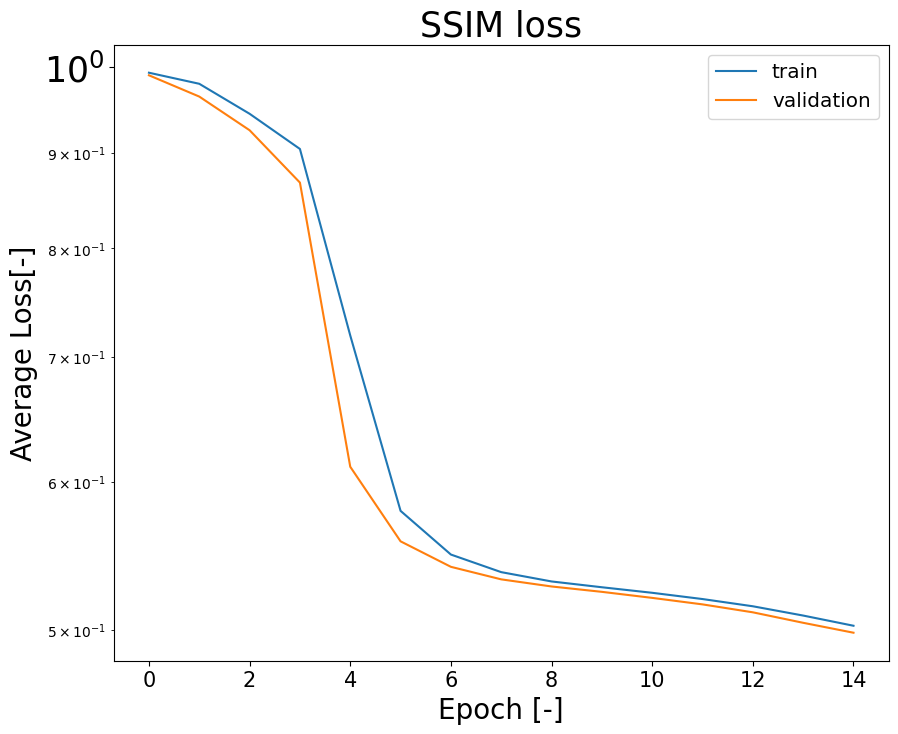

In [64]:
encoder = torch.load('linear_encoder_SSIM.pt')
decoder = torch.load('linear_decoder_SSIM.pt')

util.plot_losses(losses, loss_fn='SSIM')

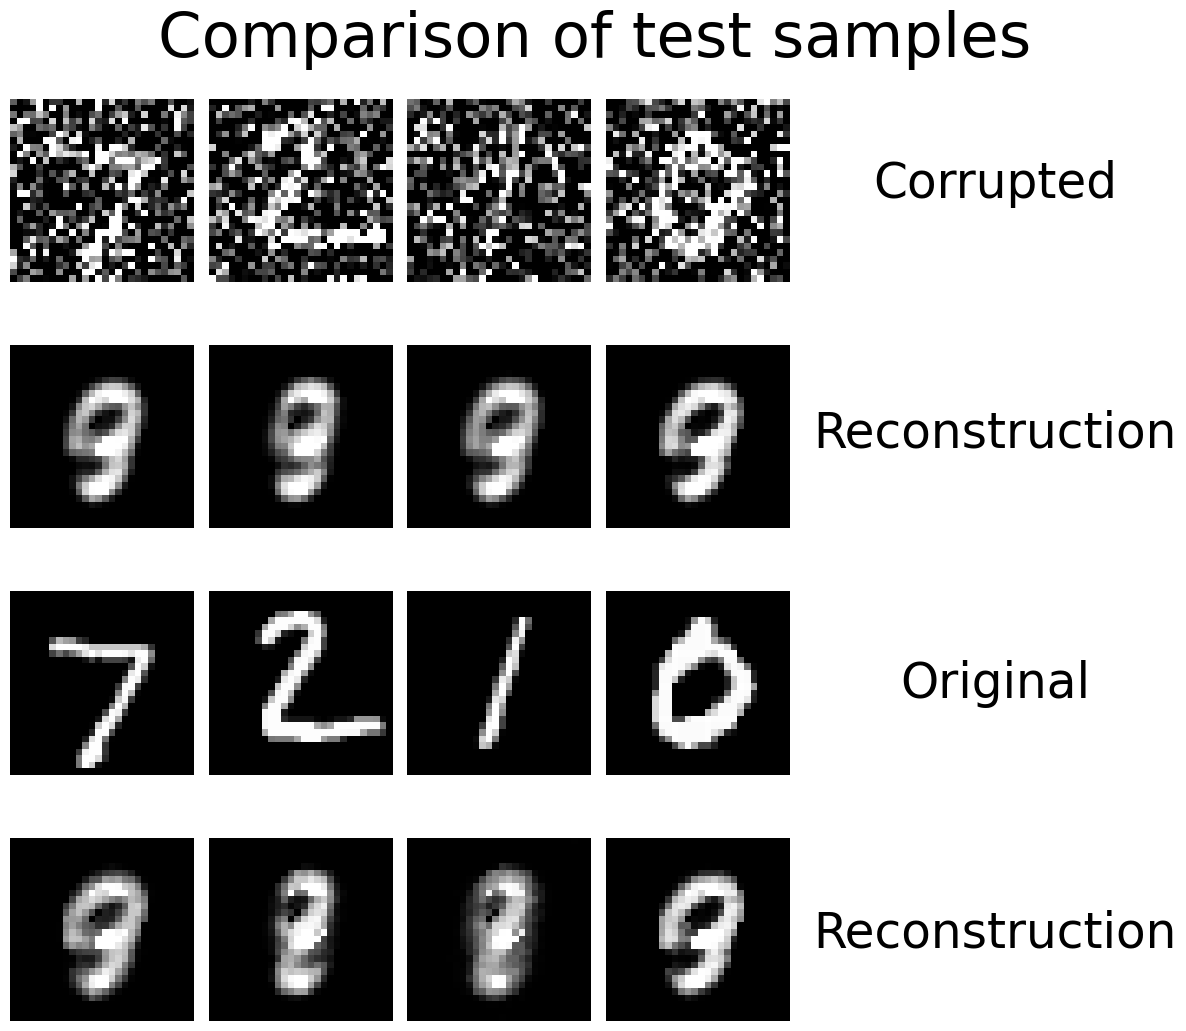

In [65]:
# test loop
outputs_inputs, test_losses = util.test(encoder, decoder, test_loader, MSEloss)

util.test_images(outputs_inputs[0], 
                 outputs_inputs[1], 
                 outputs_inputs[2], 
                 outputs_inputs[3])

# Adding hidden layers to Linear Autoencoder (Q5)

In [48]:
reload(deep_linear)
reload(util)

<module 'utils' from 'C:\\Users\\ylngu\\OneDrive\\Desktop\\5LSH0 projects\\5LSH0\\autoencoder\\utils.py'>

In [49]:
# initialize models
deep_encoder = deep_linear.Encoder(encoding_dim=30)
deep_decoder = deep_linear.Decoder(encoding_dim=30)

# for accessing both parameters
deep_autoencoder_params = [{'params': deep_encoder.parameters()},
                      {'params': deep_decoder.parameters()}]

# Adam Gradient Descent optimizer
optim = torch.optim.Adam(deep_autoencoder_params, lr=lr, weight_decay=1e-05)

In [50]:
# Define dictionary for saving the losses
losses = {'avg_train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    # train loop
    avg_train_loss, _ = util.train(deep_encoder, deep_decoder, train_loader, MSEloss, optim)
    # validation loop
    val_loss = util.validation(deep_encoder, deep_decoder, val_loader, MSEloss)
    # display losses per epoch
    print(f'Epoch {epoch+1}/{num_epochs}: train loss {avg_train_loss:.4f} \t val loss {val_loss:.4f}')
    # save losses
    losses['avg_train_loss'].append(avg_train_loss)
    losses['val_loss'].append(val_loss)
    
# Save model
torch.save(deep_encoder, 'deep_encoder.pt')
torch.save(deep_decoder, 'deep_decoder.pt')

C:\Users\ylngu\.conda\envs\Computer_Vision_5LSH0\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1/15: train loss 0.1369 	 val loss 0.0649
Epoch 2/15: train loss 0.0504 	 val loss 0.0389
Epoch 3/15: train loss 0.0347 	 val loss 0.0316
Epoch 4/15: train loss 0.0293 	 val loss 0.0272
Epoch 5/15: train loss 0.0262 	 val loss 0.0247
Epoch 6/15: train loss 0.0244 	 val loss 0.0241
Epoch 7/15: train loss 0.0235 	 val loss 0.0236
Epoch 8/15: train loss 0.0231 	 val loss 0.0230
Epoch 9/15: train loss 0.0226 	 val loss 0.0228
Epoch 10/15: train loss 0.0225 	 val loss 0.0223
Epoch 11/15: train loss 0.0221 	 val loss 0.0220
Epoch 12/15: train loss 0.0217 	 val loss 0.0212
Epoch 13/15: train loss 0.0212 	 val loss 0.0209
Epoch 14/15: train loss 0.0207 	 val loss 0.0205
Epoch 15/15: train loss 0.0204 	 val loss 0.0209


In [61]:
deep_encoder = torch.load('deep_encoder.pt')
deep_decoder = torch.load('deep_decoder.pt')

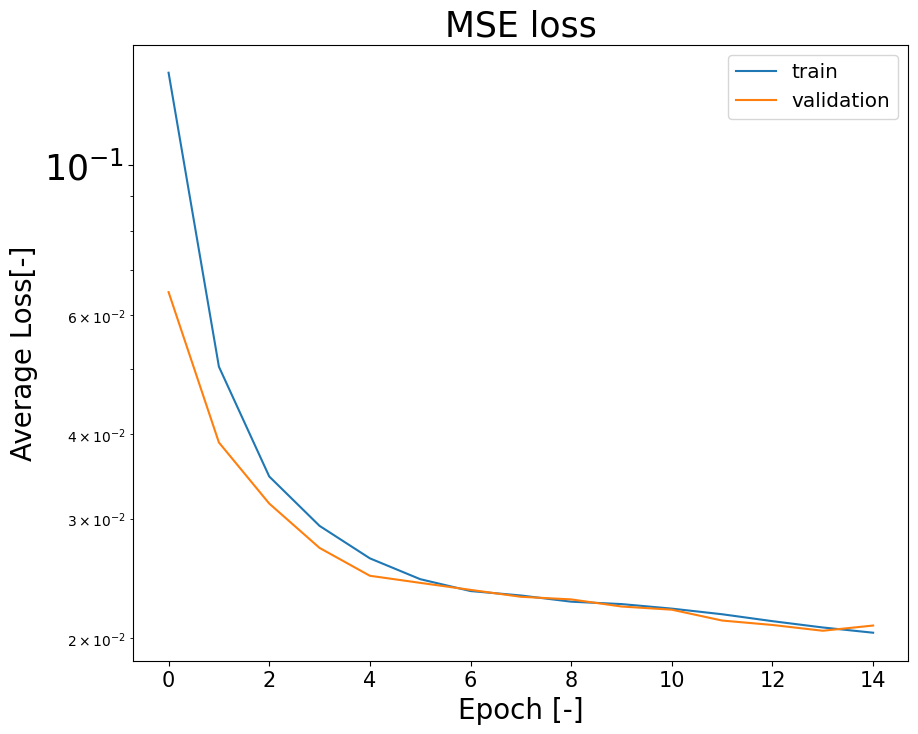

In [51]:
util.plot_losses(losses, loss_fn='MSE')

In [52]:
# test loop
outputs_inputs, _ = util.test(deep_encoder, deep_decoder, test_loader, MSEloss)

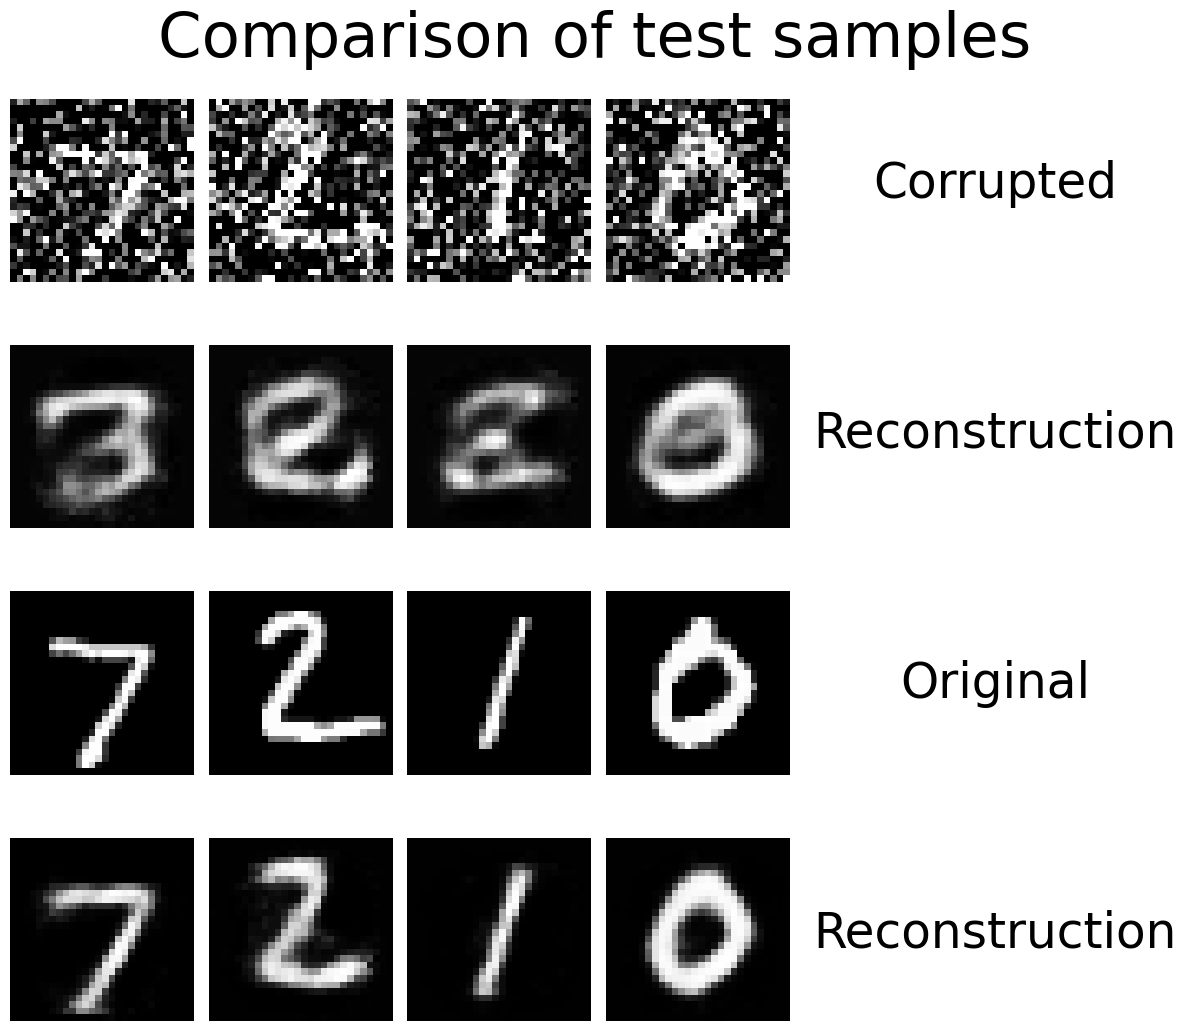

In [53]:
util.test_images(outputs_inputs[0], 
                 outputs_inputs[1], 
                 outputs_inputs[2], 
                 outputs_inputs[3])

# Convolutional autoencoder (Q6 - Q12)

In [71]:
reload(convolutional)
reload(util)

<module 'utils' from 'C:\\Users\\ylngu\\OneDrive\\Desktop\\5LSH0 projects\\5LSH0\\autoencoder\\utils.py'>

In [76]:
# initialize models
cnn_encoder = convolutional.Encoder(encoding_dim=30)
cnn_decoder = convolutional.Decoder(encoding_dim=30)

# for accessing both parameters
cnn_autoencoder_params = [{'params': cnn_encoder.parameters()},
                      {'params': cnn_decoder.parameters()}]

# Adam Gradient Descent optimizer
optim = torch.optim.Adam(cnn_autoencoder_params, lr=lr, weight_decay=1e-05)

In [77]:
# Define dictionary for saving the losses
losses = {'avg_train_loss':[],'val_loss':[], 'batch_loss': []}

for epoch in range(num_epochs):
    # train loop
    avg_train_loss, train_loss = util.train(cnn_encoder, cnn_decoder, train_loader, MSEloss, optim)
    # validation loop
    val_loss = util.validation(cnn_encoder, cnn_decoder, val_loader, MSEloss)
    # display losses per epoch
    print(f'Epoch {epoch+1}/{num_epochs}: train loss {avg_train_loss:.4f} \t val loss {val_loss:.4f}')
    # save losses
    losses['avg_train_loss'].append(avg_train_loss)
    losses['val_loss'].append(val_loss)
    losses['batch_loss'].extend(train_loss)

# Save model
torch.save(cnn_encoder, 'cnn_encoder.pt')
torch.save(cnn_decoder, 'cnn_decoder.pt')

Epoch 1/15: train loss 0.0543 	 val loss 0.0338
Epoch 2/15: train loss 0.0315 	 val loss 0.0295
Epoch 3/15: train loss 0.0232 	 val loss 0.0174
Epoch 4/15: train loss 0.0166 	 val loss 0.0161
Epoch 5/15: train loss 0.0158 	 val loss 0.0155
Epoch 6/15: train loss 0.0154 	 val loss 0.0153
Epoch 7/15: train loss 0.0151 	 val loss 0.0149
Epoch 8/15: train loss 0.0148 	 val loss 0.0148
Epoch 9/15: train loss 0.0146 	 val loss 0.0145
Epoch 10/15: train loss 0.0144 	 val loss 0.0143
Epoch 11/15: train loss 0.0142 	 val loss 0.0141
Epoch 12/15: train loss 0.0141 	 val loss 0.0140
Epoch 13/15: train loss 0.0140 	 val loss 0.0139
Epoch 14/15: train loss 0.0139 	 val loss 0.0139
Epoch 15/15: train loss 0.0139 	 val loss 0.0139


In [78]:
cnn_encoder = torch.load('cnn_encoder.pt')
cnn_decoder = torch.load('cnn_decoder.pt')

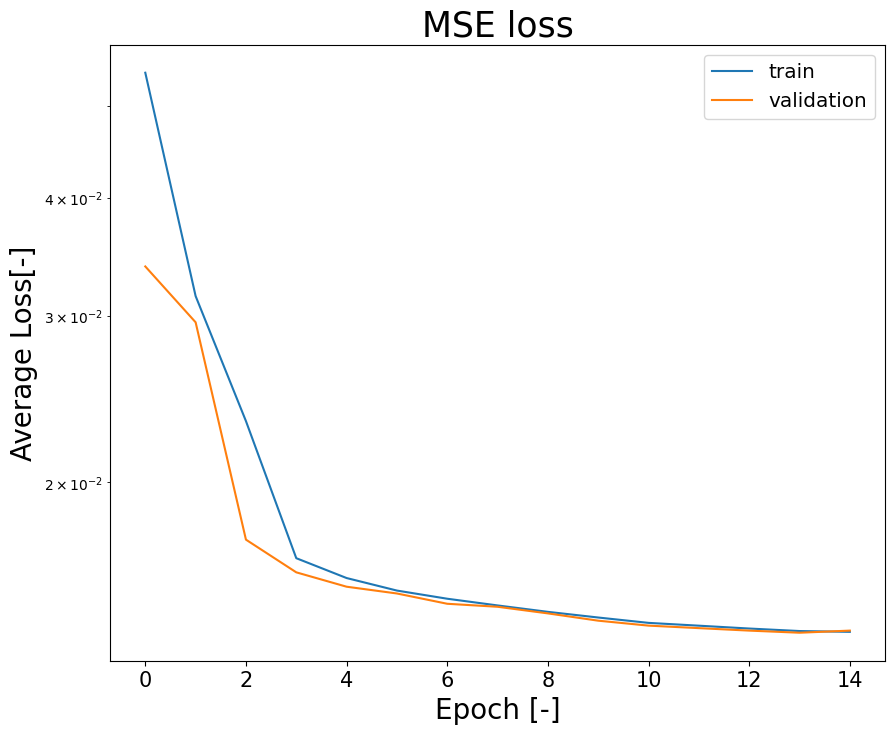

In [79]:
util.plot_losses(losses, loss_fn='MSE')

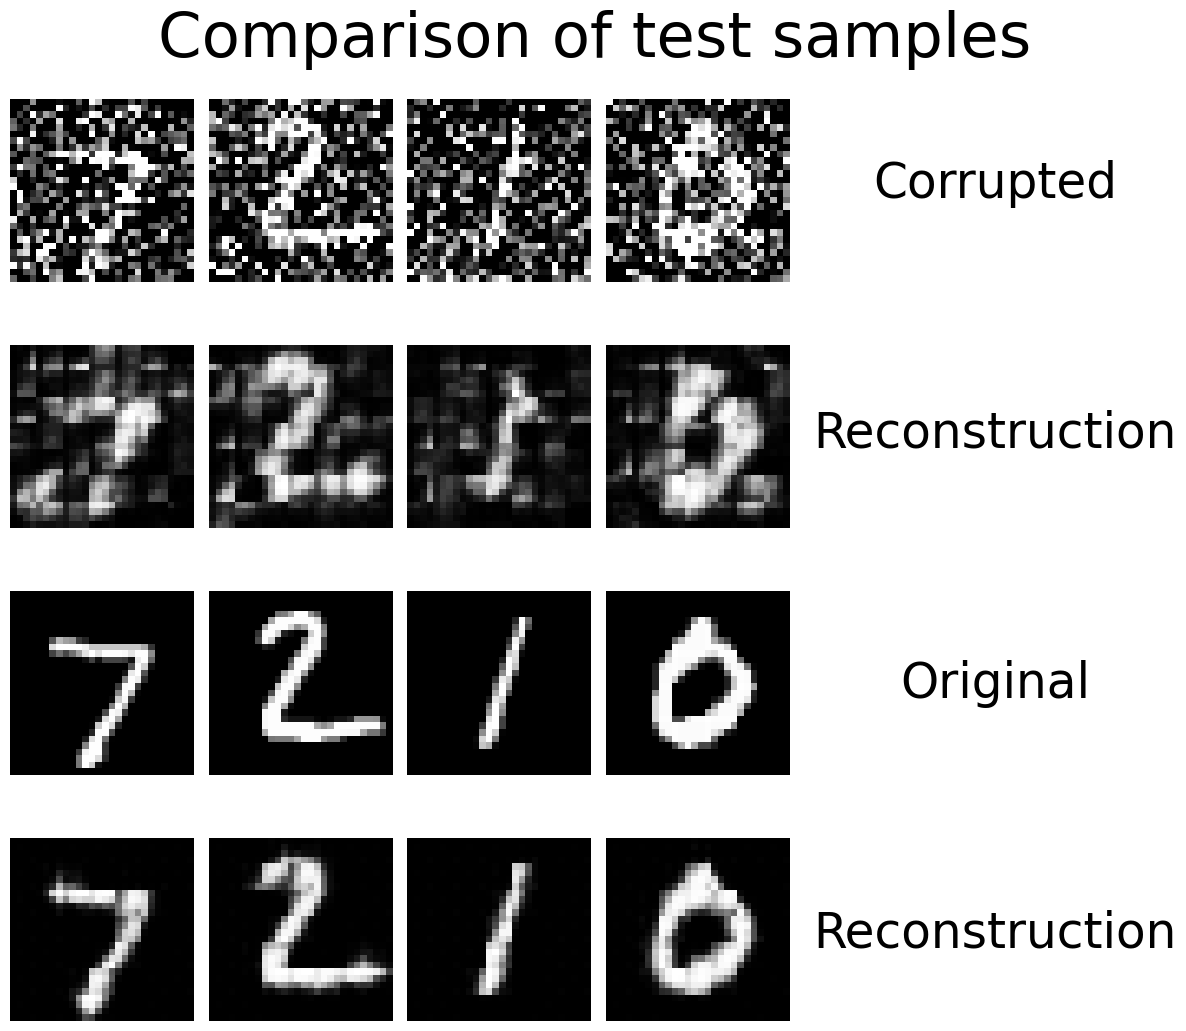

In [80]:
outputs_inputs, test_losses = util.test(cnn_encoder, cnn_decoder, test_loader, MSEloss)

util.test_images(outputs_inputs[0], 
                 outputs_inputs[1], 
                 outputs_inputs[2], 
                 outputs_inputs[3])

# Determine reconstruction error threshold

In [194]:
batch_loss = [tensor.item() for tensor in losses['batch_loss']]

# set threshold in the middle of two means
#threshold = np.mean(batch_loss) + np.mean(batch_loss)

# set threshold in the middle of two means
#threshold = np.mean(test_losses[1]) - np.std(batch_loss)

# set threshold to maximum loss in the normal mean
threshold = max(batch_loss)

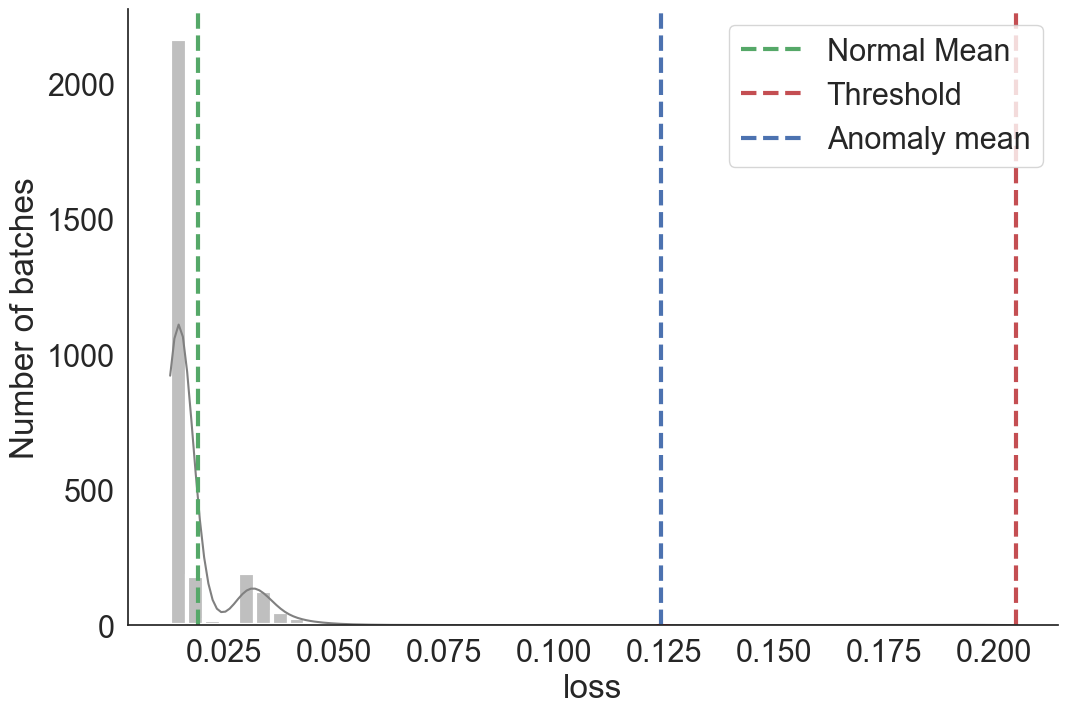

In [195]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(batch_loss ,bins=50, kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(batch_loss), color='g', linestyle='--', linewidth=3,
            label='Normal Mean')
plt.axvline(x=threshold, color='r', linestyle='--', linewidth=3, label='Threshold')

sns.histplot(test_losses[1],bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_losses[1]), color='b', linestyle='--', linewidth=3, label='Anomaly mean')
plt.xlabel("loss")
plt.ylabel("Number of batches")
plt.legend()
sns.despine()

In [205]:
# save predictions and labels in a list
preds = []
labels = []

for image_batch, _ in test_loader:
    chance = np.random.choice([0,1])
    # add noise when
    if chance == 1:
        im_in = util.add_noise(image_batch.clone())
    else: 
        im_in = image_batch
    labels.extend([chance]*image_batch.shape[0])
        
    encoded_im = encoder(im_in)
    decoded_im = decoder(encoded_im)
         
    # calculate MSE loss                    
    for i in range(image_batch.shape[0]):
        
        t_loss = MSEloss(decoded_im[i,:,:], im_in[i,:,:])
        t_loss = float(t_loss.detach().cpu().numpy())
        gt = tf.math.less(t_loss, threshold)
        
        preds.append(int(gt))

In [206]:
reload(util)
results, evaluation = util.calculate_performance(labels, preds)

TP:4686
FP:1458
TN:3
FN:3853
Precision: 0.76
Recall: 0.55
F1: 0.64


<AxesSubplot: >

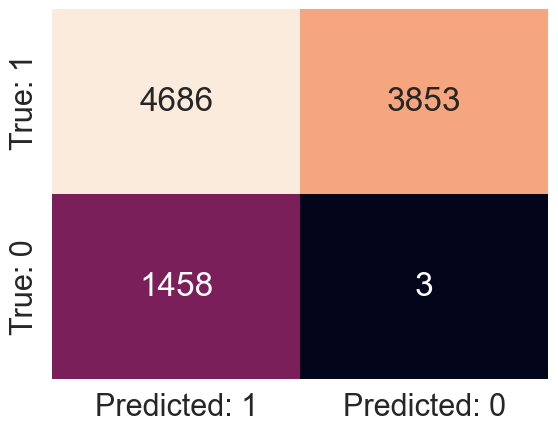

In [207]:
plt.figure()
confusion_matrix = np.reshape(np.array(results), (2,2))
sns.heatmap(data=confusion_matrix,
            xticklabels=['Predicted: 1', 'Predicted: 0'],
            yticklabels=['True: 1', 'True: 0'],
            annot=True,
            fmt='g',
            cbar=False)

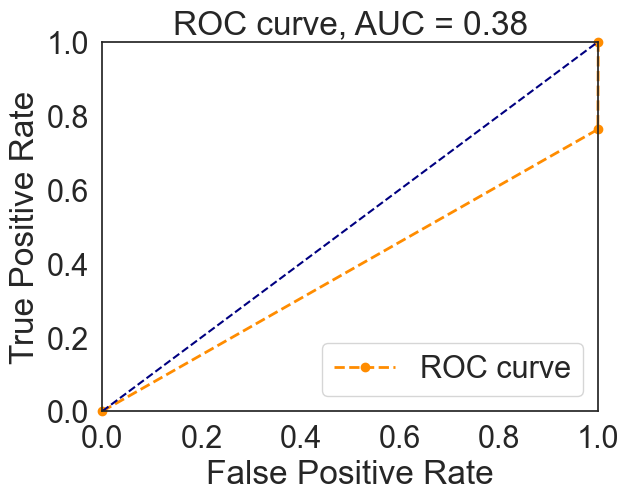

In [210]:
util.get_roc_auc(preds, labels)